In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/TrafficEmu


In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

from sumo_grid_simulation.grid_simulation import Simulator
import experimental_design.config as config

sns.set()

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [5]:
def user_function(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.1
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['routeLength'])
        i += 1
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [6]:
gridSize = DiscreteParameter('gridSize', domain=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
edgeMaxSpeed = ContinuousParameter('edgeMaxSpeed', min_value=8, max_value=19)
edgeLength = ContinuousParameter('edgeLength', min_value=30, max_value=70)
numberOfLanes = DiscreteParameter('numberOfLanes', domain=[1,2,3])
accel = ContinuousParameter('accel', 1.5, 5.)

parameter_space = ParameterSpace([gridSize, edgeMaxSpeed, edgeLength, numberOfLanes, accel])

### Get init and test points

In [7]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(20)
init_Y = user_function(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function(test_X)

[[ 4.         18.67131428 47.71480597  2.          3.15565674]
 [12.         14.03250316 38.70607845  1.          2.43666064]
 [20.         14.13882576 44.74580749  1.          2.6099119 ]
 [12.          8.81469189 37.79275611  2.          1.67544214]
 [11.         10.28108164 61.88750001  3.          2.4323018 ]
 [14.         13.29357974 56.91751101  1.          3.60572259]
 [16.         13.40056591 36.6703089   1.          4.26932148]
 [ 7.         12.17104861 63.44223443  2.          2.11066648]
 [14.         17.14347464 60.38573649  1.          4.2632416 ]
 [19.         10.53557384 52.47025918  3.          4.2055442 ]
 [19.          8.21350351 39.7575353   3.          2.8852429 ]
 [ 3.         18.71955494 59.29570065  2.          1.90419501]
 [13.         14.54576132 58.18587251  3.          2.78730532]
 [20.         14.3851716  37.30472116  1.          3.64070533]
 [19.          8.19279668 51.10545712  3.          2.76946164]
 [15.         12.90159014 46.38736761  3.          2.45

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

In [8]:
MV_Xs = []
MV_Ys = []
mses_MV = []
    
def user_function_model_variance(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.1
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['routeLength'])
        MV_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        MV_Ys.append(s['timeLoss']/s['routeLength'])

        i += 1
    
    # evaluate / validate model
    if len(MV_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_mv.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_MV.append((len(MV_Xs), rmse))
        print('EVALUATED: ', len(MV_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [9]:
emulator_mv = GPy.models.GPRegression(init_X, init_Y)
emukit_model_mv = GPyModelWrapper(emulator_mv, n_restarts=5)
emukit_model_mv.optimize()
emulator_mv

Optimization restart 1/5, f = -63.097914451964535
Optimization restart 2/5, f = -63.09791445173521
Optimization restart 3/5, f = -63.097914451972194
Optimization restart 4/5, f = -63.09791445196773
Optimization restart 5/5, f = -34.95369745249717


GP_regression.,value,constraints,priors
rbf.variance,0.004209722159669738,+ve,
rbf.lengthscale,29.115857923275996,+ve,
Gaussian_noise.variance,1.8932823287217294e-05,+ve,


#### Acquisition Function

In [10]:
model_variance = ModelVariance(model=emukit_model_mv)

#### Optimizer

In [11]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [12]:
ed_loop_mv = ExperimentalDesignLoop(
    model = emukit_model_mv,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [13]:
ed_loop_mv.run_loop(user_function_model_variance, 750)

Optimization restart 1/5, f = -63.097914451972194
Optimization restart 2/5, f = -63.09791445196932
Optimization restart 3/5, f = -63.097914451974034
Optimization restart 4/5, f = -63.09791445197375
Optimization restart 5/5, f = -58.71820795470284
[[20.          8.84513542 69.51883186  1.          4.15819992]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -65.26720553288955
Optimization restart 2/5, f = -65.26720553317203
Optimization restart 3/5, f = -65.26720553318896
Optimization restart 4/5, f = -65.26720553251167
Optimization restart 5/5, f = -65.2672055331977
[[ 3.          8.49866044 69.57200814  3.          4.4640549 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -68.74116455889002
Optimization restart 2/5, f = -68.74116455897993
Optimization restart 3/5, f = -68.74116455976208
Optimization resta

 Retrying in 1 seconds
Optimization restart 1/5, f = -112.41818489562361
Optimization restart 2/5, f = -64.49127802092434
Optimization restart 3/5, f = -64.49132254073528
Optimization restart 4/5, f = -112.41818489676346
Optimization restart 5/5, f = -64.49127761460281
[[ 3.         18.82513826 35.773988    1.          4.99937568]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -115.76412777748791
Optimization restart 2/5, f = -115.7641277774063
Optimization restart 3/5, f = -65.7741404114542
Optimization restart 4/5, f = -115.76412777558573
Optimization restart 5/5, f = -115.7641277773084
[[16.         17.72896652 69.88350366  1.          1.62954022]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -119.38997167892748
Optimization restart 2/5, f = -119.38997612222956
Optimization restart 3/5, f = -67.429289

 Retrying in 1 seconds
Optimization restart 1/5, f = -160.56313047226027
Optimization restart 2/5, f = -160.5631304687606
Optimization restart 3/5, f = -92.59839247884325
Optimization restart 4/5, f = -160.56313047226593
Optimization restart 5/5, f = -160.5631304618639
[[20.         17.67648099 30.37159126  1.          1.68692659]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -163.74693194021407
Optimization restart 2/5, f = -153.82947426226417
Optimization restart 3/5, f = -163.74693194032255
Optimization restart 4/5, f = -163.74693193966758
Optimization restart 5/5, f = -163.74693193760228
[[ 3.         15.2995728  30.31912049  3.          4.33761031]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds
Optimization restart 1/5, f = -166.8656083388366
Optimization restart 2/5, f = -166.8656083447844
Optimization restart 3/5, f = -166.86560834319235
Optimization restart 4/5, f = -95.24845398365636
Optimization restart 5/5, f = -166.8656083446608
[[20.         18.69586015 54.24435324  1.          1.82158302]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -169.99516891723601
Optimization restart 2/5, f = -169.99516891730755
Optimization restart 3/5, f = -169.99516891730556
Optimization restart 4/5, f = -96.82024036558231
Optimization restart 5/5, f = -169.9951689171481
[[ 3.         18.8862336  46.83507218  3.          4.50552697]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -172.738991281999
Optimization restart 2/5, f = -98.33245746392284
Optimization restart 3/5, f = -98.33244265

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -211.4208995151499
[[14.         18.98496361 50.22738784  3.          1.56399495]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -215.01231138481904
Optimization restart 2/5, f = -215.0123113850284
Optimization restart 3/5, f = -215.0123113850391
Optimization restart 4/5, f = -215.01231138213245
Optimization restart 5/5, f = -215.01231138179185
[[20.         11.86670856 69.01481633  3.          4.88355899]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -218.68961135091516
Optimization restart 2/5, f = -218.68961135094034
Optimization restart 3/5, f = -218.68961135090964
Optimization restart 4/5, f = -218.68961135046004
Optimization restart 5/5, f = -218.6896113509456
[[ 3.          8.16308646 68.47955613  1.          1.59822292]]

User function time loss called with 1 inputs 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -235.611753999418
Optimization restart 4/5, f = -235.61175398976107
Optimization restart 5/5, f = -235.61175399943042
[[20.         18.04015408 30.82980174  3.          1.51383864]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -94.11772330070197
Optimization restart 2/5, f = -94.11772330069857
Optimization restart 3/5, f = -94.11772330047191
Optimization restart 4/5, f = -94.11772330059465
Optimization restart 5/5, f = -94.11772330056529
[[ 3.          8.99476076 30.43412143  2.          4.775189  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -95.73390117674208
Optimization restart 2/5, f = -95.73463166194412
Optimization restart 3/5, f = -95.73463167035746
Optimization restart 4/5, f = -95.73463166479499
Optimization restart 5/5, f = -78.9890093096339
[[20.          8.36

 Retrying in 1 seconds
Optimization restart 1/5, f = -124.81697404710683
Optimization restart 2/5, f = -124.81933310574779
Optimization restart 3/5, f = -101.4686350373989
Optimization restart 4/5, f = -124.8193331057702
Optimization restart 5/5, f = -124.8193331001938
[[19.         18.85011248 69.75402364  3.          2.95235921]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -126.55862118307286
Optimization restart 2/5, f = -102.8738921789008
Optimization restart 3/5, f = -126.55865567229952
Optimization restart 4/5, f = -126.55865567323872
Optimization restart 5/5, f = -126.5586556731163
[[20.         17.50206349 30.48649372  3.          4.82551002]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -100.26528037138148
Optimization restart 2/5, f = -100.26528037120512
Optimization restart 3/5, f = -100.265

Optimization restart 4/5, f = -123.85471895542968
Optimization restart 5/5, f = -123.85471896782256
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -125.37500241328897
Optimization restart 2/5, f = -107.94370881596603
Optimization restart 3/5, f = -107.94370934812594
Optimization restart 4/5, f = -125.37504886922005
Optimization restart 5/5, f = -125.37504888221464
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -126.90632088785084
Optimization restart 2/5, f = -126.9064186266458
Optimization restart 3/5, f = -107.18146915783427
Optimization restart 4/5, f = -126.90641880025534
Optimization restart 5/5, f = -126.90641880024462
[[ 3.          8.         48.72406658  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating inp

 Retrying in 1 seconds
Optimization restart 1/5, f = -150.90346130310894
Optimization restart 2/5, f = -150.9034989346507
Optimization restart 3/5, f = -135.9833091432639
Optimization restart 4/5, f = -150.9034989201293
Optimization restart 5/5, f = -150.9034989369006
[[ 3.          8.         70.          1.          3.05069539]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -152.49153478090312
Optimization restart 2/5, f = -152.4915592983305
Optimization restart 3/5, f = -137.28060013102134
Optimization restart 4/5, f = -137.28060008423523
Optimization restart 5/5, f = -152.49155929800543
[[ 3.  19.  70.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -154.05453551249
Optimization restart 2/5, f = -154.05459690383464
Optimization restart 3/5, f = -138.5442733274493
Optimization restart 4/5, f

Optimization restart 4/5, f = -176.11386534289096
Optimization restart 5/5, f = -166.71751168556418
[[ 9.          8.         42.58998414  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -177.75425070780798
Optimization restart 2/5, f = -177.75425071077518
Optimization restart 3/5, f = -177.75425071196847
Optimization restart 4/5, f = -177.75425071003673
Optimization restart 5/5, f = -167.98093857720445
[[ 3.          8.         55.87536949  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -179.40330524404146
Optimization restart 2/5, f = -169.27987193551553
Optimization restart 3/5, f = -169.2798719099311
Optimization restart 4/5, f = -179.4033567534886
Optimization restart 5/5, f = -179.40335675358165
[[20.          8.         56.96129048  3.          5.     

 Retrying in 1 seconds
Optimization restart 1/5, f = -209.23125765392567
Optimization restart 2/5, f = -195.8871723665928
Optimization restart 3/5, f = -209.23126377845858
Optimization restart 4/5, f = -209.2312635486945
Optimization restart 5/5, f = -209.23126378171594
[[ 3.         19.         40.15948641  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -210.90045676019028
Optimization restart 2/5, f = -196.841152253062
Optimization restart 3/5, f = -196.84114940130982
Optimization restart 4/5, f = -196.84115239117946
Optimization restart 5/5, f = -210.9006381453044
[[11.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -212.59880908288307
Optimization restart 2/5, f = -212.59881355903516
Optimization restart 3/5, f = -212.59881356594292
Optimization restart 4/

 Retrying in 1 seconds
Optimization restart 1/5, f = -243.4208554544644
Optimization restart 2/5, f = -243.4208554544961
Optimization restart 3/5, f = -222.3782909146696
Optimization restart 4/5, f = -243.42085545494444
Optimization restart 5/5, f = -222.378289961327
[[10. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -245.18536410025263
Optimization restart 2/5, f = -223.78000340432845
Optimization restart 3/5, f = -245.18539769426675
Optimization restart 4/5, f = -245.18539769360888
Optimization restart 5/5, f = -223.78000293565043
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -245.16323090724075
Optimization restart 2/5, f = -245.1632309056492
Optimization restart 3/5, f = -225.0999606459451
Optimization restart 4/5, f = -245.1632308881113
Optimization res

Optimization restart 3/5, f = -277.1216606882518
Optimization restart 4/5, f = -256.3285310095256
Optimization restart 5/5, f = -256.32853061201007
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -278.7698168090954
Optimization restart 2/5, f = -264.2733597083569
Optimization restart 3/5, f = -264.27310793767555
Optimization restart 4/5, f = -278.7701555920476
Optimization restart 5/5, f = -264.2733592836437
[[ 9.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -280.6036937967026
Optimization restart 2/5, f = -265.6574996117081
Optimization restart 3/5, f = -265.6575019847702
Optimization restart 4/5, f = -280.6036963087931
Optimization restart 5/5, f = -265.65750191712095
[[12.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluati

 Retrying in 1 seconds
Optimization restart 1/5, f = -312.8658109506341
Optimization restart 2/5, f = -305.03173804954747
Optimization restart 3/5, f = -305.03173835622954
Optimization restart 4/5, f = -312.8658109500893
Optimization restart 5/5, f = -305.0317381847045
[[ 3.         19.         38.15009363  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -314.7247189452714
Optimization restart 2/5, f = -314.72472447485904
Optimization restart 3/5, f = -306.30833485055393
Optimization restart 4/5, f = -306.30838629659104
Optimization restart 5/5, f = -306.30842935225667
[[ 3.         13.73932305 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -316.59106038008804
Optimization restart 2/5, f = -307.7428005209018
Optimization restart 3/5, f = -316.591

 Retrying in 1 seconds
Optimization restart 1/5, f = -350.1289276119109
Optimization restart 2/5, f = -350.12891806381236
Optimization restart 3/5, f = -350.1289298235455
Optimization restart 4/5, f = -350.1289296532899
Optimization restart 5/5, f = -349.3161370854982
[[ 8.         12.47745342 54.6456502   3.          3.96249633]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -351.5622517617672
Optimization restart 2/5, f = -351.2394321550463
Optimization restart 3/5, f = -351.5622512124869
Optimization restart 4/5, f = -351.56225115468214
Optimization restart 5/5, f = -351.23943215995575
[[ 7.         12.58371847 36.90552897  1.          4.51824029]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -352.9886721358782
Optimization restart 2/5, f = -352.98867123534257
Optimization restart 3/5, f = -353.119839

 Retrying in 1 seconds
Optimization restart 1/5, f = -386.065106293987
Optimization restart 2/5, f = -382.8698880475582
Optimization restart 3/5, f = -386.06522880081076
Optimization restart 4/5, f = -386.06522880076625
Optimization restart 5/5, f = -386.0652287932748
[[ 3.         14.61732832 60.39725323  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -388.01414760090324
Optimization restart 2/5, f = -384.31846750220177
Optimization restart 3/5, f = -384.31846658786236
Optimization restart 4/5, f = -388.01414761658543
Optimization restart 5/5, f = -388.0141473864028
[[ 9.         19.         61.97443699  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -389.96164746774906
Optimization restart 2/5, f = -385.6506505522573
Optimization restart 3/5, f = -385.6506

 Retrying in 1 seconds
Optimization restart 1/5, f = -427.8619241518729
Optimization restart 2/5, f = -427.861892759649
Optimization restart 3/5, f = -427.86192332323327
Optimization restart 4/5, f = -425.35036277662323
Optimization restart 5/5, f = -427.8619063135689
[[ 9.         16.57741972 35.21094386  1.          2.15188085]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -429.2003398553252
Optimization restart 2/5, f = -427.2386935434556
Optimization restart 3/5, f = -429.20033856465403
Optimization restart 4/5, f = -429.20033722893265
Optimization restart 5/5, f = -427.23869356366356
[[16.          8.72917082 34.76687053  2.          1.85682926]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -430.6525906071573
Optimization restart 2/5, f = -429.24893317008906
Optimization restart 3/5, f = -429.24893

 Retrying in 1 seconds
Optimization restart 1/5, f = -463.28070994095924
Optimization restart 2/5, f = -460.8963126367771
Optimization restart 3/5, f = -463.28071641676706
Optimization restart 4/5, f = -460.8963705045065
Optimization restart 5/5, f = -460.8963616854427
[[20.         12.62561798 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -465.302372376236
Optimization restart 2/5, f = -462.42805247223345
Optimization restart 3/5, f = -465.30237242293526
Optimization restart 4/5, f = -465.3023724245314
Optimization restart 5/5, f = -465.30237229430315
[[20.         12.58777367 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -466.6217322208022
Optimization restart 2/5, f = -464.012153512516
Optimization restart 3/5, f = -466.6217322

 Retrying in 1 seconds
Optimization restart 1/5, f = -502.8614103714248
Optimization restart 2/5, f = -502.86144978087333
Optimization restart 3/5, f = -503.26244525141885
Optimization restart 4/5, f = -502.8614671222816
Optimization restart 5/5, f = -503.2624452357209
[[ 3.          8.         62.20762927  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -505.332068267586
Optimization restart 2/5, f = -505.33211884553157
Optimization restart 3/5, f = -504.41775949558917
Optimization restart 4/5, f = -505.33211884147715
Optimization restart 5/5, f = -505.33211884467084
[[ 3.         19.         63.18599369  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -507.4095909868869
Optimization restart 2/5, f = -505.9456522804161
Optimization restart 3/5, f = -505.94594

 Retrying in 1 seconds
Optimization restart 1/5, f = -544.8229044968884
Optimization restart 2/5, f = -544.822937223585
Optimization restart 3/5, f = -544.8229372220364
Optimization restart 4/5, f = -532.28090651208
Optimization restart 5/5, f = -544.8229372236697
[[ 9.         12.70446435 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -546.9393235670681
Optimization restart 2/5, f = -533.84710476714
Optimization restart 3/5, f = -546.9393234996039
Optimization restart 4/5, f = -546.9393235879384
Optimization restart 5/5, f = -546.9393235864369
[[20.         13.8437477  59.31536627  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -549.0408303438121
Optimization restart 2/5, f = -549.040847791266
Optimization restart 3/5, f = -535.2373051787264
Op

 Retrying in 1 seconds
Optimization restart 1/5, f = -586.7793469515448
Optimization restart 2/5, f = -586.7793475638817
Optimization restart 3/5, f = -581.2672161183152
Optimization restart 4/5, f = -581.2672160858081
Optimization restart 5/5, f = -586.7793475616852
[[20.         19.         41.39956415  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -588.6958254708163
Optimization restart 2/5, f = -588.6958254611811
Optimization restart 3/5, f = -582.8231097811595
Optimization restart 4/5, f = -588.6958254710926
Optimization restart 5/5, f = -588.6958254702563
[[11.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -590.8389527865709
Optimization restart 2/5, f = -584.4184876466048
Optimization restart 3/5, f = -584.4184891774323
Optimization restart 4/5, f = -584.4

Optimization restart 1/5, f = -632.2023499393911
Optimization restart 2/5, f = -632.2023496843528
Optimization restart 3/5, f = -628.7797812402829
Optimization restart 4/5, f = -632.2023488964953
Optimization restart 5/5, f = -632.2023494583681
[[12.         13.84639832 42.77879321  1.          4.6995227 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -633.7281439934152
Optimization restart 2/5, f = -630.9170825896825
Optimization restart 3/5, f = -633.7281440274282
Optimization restart 4/5, f = -630.9170825812541
Optimization restart 5/5, f = -633.7281360892555
[[17.         14.92931829 55.75236275  3.          1.70691558]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -635.185261522895
Optimization restart 2/5, f = -633.1158916272044
Optimization restart 3/5, f = -633.1158910918871
Optimization restart

 Retrying in 1 seconds
Optimization restart 1/5, f = -674.9762455231055
Optimization restart 2/5, f = -672.6230279339724
Optimization restart 3/5, f = -672.6230279337259
Optimization restart 4/5, f = -672.6230279317132
Optimization restart 5/5, f = -674.9762399427646
[[ 5.         14.56526065 56.08246767  3.          1.50824407]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -676.4228517820065
Optimization restart 2/5, f = -676.422663670604
Optimization restart 3/5, f = -674.8466298979383
Optimization restart 4/5, f = -674.8466297712763
Optimization restart 5/5, f = -674.8466299055995
[[15.          9.97121138 49.33953986  1.          1.86775862]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -678.0009824769013
Optimization restart 2/5, f = -678.0009820247263
Optimization restart 3/5, f = -678.00098200075

 Retrying in 1 seconds
Optimization restart 1/5, f = -710.9447202661427
Optimization restart 2/5, f = -710.944720281433
Optimization restart 3/5, f = -710.9581551931884
Optimization restart 4/5, f = -710.9581551144843
Optimization restart 5/5, f = -710.9581551935332
[[ 3.         19.         35.45298896  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -713.1719639377588
Optimization restart 2/5, f = -713.1719661453357
Optimization restart 3/5, f = -712.3471744141837
Optimization restart 4/5, f = -713.1719659517836
Optimization restart 5/5, f = -713.1719661078245
[[ 3.         8.        54.7469449  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -715.3901501405774
Optimization restart 2/5, f = -713.9828506583947
Optimization restart 3/5, f = -713.9828456504199
Op

 Retrying in 1 seconds
Optimization restart 1/5, f = -753.1802922501657
Optimization restart 2/5, f = -742.389343741618
Optimization restart 3/5, f = -753.1802922501714
Optimization restart 4/5, f = -753.180292242521
Optimization restart 5/5, f = -742.3893432108822
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -755.4093790235942
Optimization restart 2/5, f = -750.3341736962232
Optimization restart 3/5, f = -755.4093840993323
Optimization restart 4/5, f = -755.4093841344272
Optimization restart 5/5, f = -750.3341711256099
[[11.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -757.6087801752756
Optimization restart 2/5, f = -757.6089025671743
Optimization restart 3/5, f = -752.0631679126884
Optimization restart 4/5, f = -757.6089027825988
Optimization restar

Optimization restart 1/5, f = -796.2347823351924
Optimization restart 2/5, f = -787.8497318986814
Optimization restart 3/5, f = -787.8497315957029
Optimization restart 4/5, f = -796.2348526603561
Optimization restart 5/5, f = -796.2348526561123
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -798.4903162122652
Optimization restart 2/5, f = -795.9384002390843
Optimization restart 3/5, f = -798.4903328666137
Optimization restart 4/5, f = -795.9384012316366
Optimization restart 5/5, f = -795.9383981195733
[[20.        19.        38.4124804  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -800.6050164570871
Optimization restart 2/5, f = -800.6052518038696
Optimization restart 3/5, f = -800.6052521849164
Optimization restart 4/5, f = -797.6277227706805
Optimizati

Optimization restart 1/5, f = -835.3128686343048
Optimization restart 2/5, f = -835.3128686342258
Optimization restart 3/5, f = -835.3128686334022
Optimization restart 4/5, f = -831.5416894023358
Optimization restart 5/5, f = -835.3128686342742
[[16.         15.00539302 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -837.6075908184172
Optimization restart 2/5, f = -833.0538121806813
Optimization restart 3/5, f = -833.0538130282875
Optimization restart 4/5, f = -833.0538126640718
Optimization restart 5/5, f = -837.6075958863881
[[ 3.          8.         63.95936853  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -839.90071312433
Optimization restart 2/5, f = -839.9007145866665
Optimization restart 3/5, f = -839.9007145858218
Optimization restart 

 Retrying in 1 seconds
Optimization restart 1/5, f = -878.5326693699365
Optimization restart 2/5, f = -878.5326688904796
Optimization restart 3/5, f = -878.5326679913629
Optimization restart 4/5, f = -878.5326687704819
Optimization restart 5/5, f = -877.7634608602946
[[13.         18.47436616 56.53629688  2.          2.03780556]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -880.02847152249
Optimization restart 2/5, f = -880.0999165063349
Optimization restart 3/5, f = -880.0999139718955
Optimization restart 4/5, f = -880.0284603750933
Optimization restart 5/5, f = -880.028466115173
[[12.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -882.4113401912972
Optimization restart 2/5, f = -882.4113403337076
Optimization restart 3/5, f = -887.9733005195673
Optimization restart 4/5, f = -887

 Retrying in 1 seconds
Optimization restart 1/5, f = -925.6820083000673
Optimization restart 2/5, f = -921.6345367386887
Optimization restart 3/5, f = -921.6345367378234
Optimization restart 4/5, f = -921.6345366906787
Optimization restart 5/5, f = -921.6345367359754
[[16.         13.34952649 43.11471268  1.          4.78741941]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -927.2973742831612
Optimization restart 2/5, f = -927.2973350305426
Optimization restart 3/5, f = -927.2973603477519
Optimization restart 4/5, f = -923.9822042905496
Optimization restart 5/5, f = -923.9822058566888
[[16.          8.76859103 59.95018445  1.          2.52623548]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -928.9459810536516
Optimization restart 2/5, f = -928.9459808467352
Optimization restart 3/5, f = -926.3550277966

 Retrying in 1 seconds
Optimization restart 1/5, f = -963.0370100475684
Optimization restart 2/5, f = -963.0370100775917
Optimization restart 3/5, f = -963.0370100598259
Optimization restart 4/5, f = -963.0370100759208
Optimization restart 5/5, f = -963.0370100776145
[[20.         14.27874025 55.47076824  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -965.3961025150793
Optimization restart 2/5, f = -958.1719508019596
Optimization restart 3/5, f = -965.3961090274582
Optimization restart 4/5, f = -958.1719516429805
Optimization restart 5/5, f = -958.171951744926
[[ 3.         8.        45.4335003  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -967.7418034089438
Optimization restart 2/5, f = -967.741803512529
Optimization restart 3/5, f = -967.7418034420626
Opt

 Retrying in 1 seconds
Optimization restart 1/5, f = -1005.9327620590484
Optimization restart 2/5, f = -1005.9327680217779
Optimization restart 3/5, f = -1005.9327680220694
Optimization restart 4/5, f = -1005.9327680238944
Optimization restart 5/5, f = -1005.9327680245785
[[ 8.         19.         56.32647546  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1008.2985596564923
Optimization restart 2/5, f = -1008.2986187330566
Optimization restart 3/5, f = -1008.2986187708862
Optimization restart 4/5, f = -1008.2986182227406
Optimization restart 5/5, f = -1008.2986187693923
[[ 3.         11.50326764 65.34900111  1.          1.77282999]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1010.6810020490175
Optimization restart 2/5, f = -1010.6810030005172
Optimization restart 3/5, f = -10

 Retrying in 1 seconds
Optimization restart 1/5, f = -1052.5804655484712
Optimization restart 2/5, f = -1052.580558009601
Optimization restart 3/5, f = -1052.5805575683316
Optimization restart 4/5, f = -1026.3924446052029
Optimization restart 5/5, f = -1052.5805580097285
[[10.         19.         34.00722885  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1054.9618017764
Optimization restart 2/5, f = -1027.621046420722
Optimization restart 3/5, f = -1054.961802856466
Optimization restart 4/5, f = -1027.620917704664
Optimization restart 5/5, f = -1054.9618028512277
[[20.         19.         61.30436936  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1057.3596624747283
Optimization restart 2/5, f = -1057.3596637032538
Optimization restart 3/5, f = -1057.3596

Optimization restart 5/5, f = -1057.7010067110182
[[20.         10.39980594 65.70672414  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1097.0685909604445
Optimization restart 2/5, f = -1097.0686028580396
Optimization restart 3/5, f = -1059.3741477408844
Optimization restart 4/5, f = -1097.0686028674058
Optimization restart 5/5, f = -1059.3741486536521
[[20.         19.         60.39544838  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1099.4849996202754
Optimization restart 2/5, f = -1099.4849999666735
Optimization restart 3/5, f = -1099.4849999728726
Optimization restart 4/5, f = -1099.484999033547
Optimization restart 5/5, f = -1099.484999970389
[[17.         19.         48.91905047  3.          5.        ]]

User function time loss called with 1 input

 Retrying in 1 seconds
Optimization restart 1/5, f = -1122.089945287065
Optimization restart 2/5, f = -1122.089946661978
Optimization restart 3/5, f = -1101.3082631053753
Optimization restart 4/5, f = -1122.0899467106221
Optimization restart 5/5, f = -1122.0899466398057
[[20.         19.         51.28541828  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1124.4740173157809
Optimization restart 2/5, f = -1102.752428084645
Optimization restart 3/5, f = -1102.7524280155315
Optimization restart 4/5, f = -1124.4740306248596
Optimization restart 5/5, f = -1102.7524044890515
[[20.         19.         66.30941408  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1126.8609156241741
Optimization restart 2/5, f = -1126.8609158090244
Optimization restart 3/5, f = -1104.

 Retrying in 1 seconds
Optimization restart 1/5, f = -1164.5000364779307
Optimization restart 2/5, f = -1138.7801875498494
Optimization restart 3/5, f = -1138.7799854270245
Optimization restart 4/5, f = -1138.7801775334076
Optimization restart 5/5, f = -1164.5000509043361
[[ 6.         14.19822429 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1166.9003895642559
Optimization restart 2/5, f = -1166.9003905809086
Optimization restart 3/5, f = -1166.9003906185292
Optimization restart 4/5, f = -1166.9003906194953
Optimization restart 5/5, f = -1166.9003905690704
[[20.         12.65011457 65.29502283  3.          1.74519827]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1169.3101812414293
Optimization restart 2/5, f = -1141.9969556395604
Optimization restart 3/5, f = -11

Optimization restart 5/5, f = -1175.5052508956355
[[ 3.         14.34799716 38.16346488  1.          1.57580094]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1211.7667347830525
Optimization restart 2/5, f = -1211.766738128435
Optimization restart 3/5, f = -1211.7667381283816
Optimization restart 4/5, f = -1211.7667381285676
Optimization restart 5/5, f = -1211.7667381284862
[[ 8.         16.97648505 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1214.1516360318608
Optimization restart 2/5, f = -1214.1517543440032
Optimization restart 3/5, f = -1214.1517542996628
Optimization restart 4/5, f = -1178.5311728926088
Optimization restart 5/5, f = -1214.1517543455234
[[ 3.        19.        56.1982438  1.         1.5      ]]

User function time loss called with 1 inputs to

Optimization restart 5/5, f = -1238.1585504001603
[[ 3.         8.        38.7532661  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1258.5821424247229
Optimization restart 2/5, f = -1258.5821655478976
Optimization restart 3/5, f = -1241.6770855464395
Optimization restart 4/5, f = -1258.5821655478585
Optimization restart 5/5, f = -1258.582165423745
[[13.          8.         35.86330497  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1261.0105762094036
Optimization restart 2/5, f = -1261.0105858540692
Optimization restart 3/5, f = -1261.0105859611817
Optimization restart 4/5, f = -1261.0105858990405
Optimization restart 5/5, f = -1243.392724814685
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1


Optimization restart 2/5, f = -1303.0594252973174
Optimization restart 3/5, f = -1291.238573615403
Optimization restart 4/5, f = -1291.2395504501603
Optimization restart 5/5, f = -1303.05942527553
[[16. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1305.2196544631142
Optimization restart 2/5, f = -1305.219654436658
Optimization restart 3/5, f = -1293.3637371511686
Optimization restart 4/5, f = -1305.2196544631715
Optimization restart 5/5, f = -1305.2196544553437
[[ 3.          8.         45.10656517  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1307.6623107905489
Optimization restart 2/5, f = -1307.662321353359
Optimization restart 3/5, f = -1307.6623214371195
Optimization restart 4/5, f = -1307.6623214382907
Optimization restart 5/5, f = -1307.6623214382505
[

 Retrying in 1 seconds
Optimization restart 1/5, f = -1345.7126547047412
Optimization restart 2/5, f = -1337.3203080258415
Optimization restart 3/5, f = -1337.3191185247265
Optimization restart 4/5, f = -1345.712654551544
Optimization restart 5/5, f = -1345.7126546623235
[[12.         19.         38.46088509  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1348.1534877514182
Optimization restart 2/5, f = -1338.9979004217453
Optimization restart 3/5, f = -1338.997886499572
Optimization restart 4/5, f = -1348.1537545351125
Optimization restart 5/5, f = -1338.9979009673455
[[ 3.         18.03234129 62.59714234  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1350.6261457114538
Optimization restart 2/5, f = -1350.6261481382512
Optimization restart 3/5, f = -1350

 Retrying in 1 seconds
Optimization restart 1/5, f = -1394.2315379122829
Optimization restart 2/5, f = -1375.6795048549473
Optimization restart 3/5, f = -1394.2315544105409
Optimization restart 4/5, f = -1375.6794383296378
Optimization restart 5/5, f = -1394.2315544555531
[[20.         19.         34.91792397  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1396.460332095017
Optimization restart 2/5, f = -1378.2083360339689
Optimization restart 3/5, f = -1396.4603318667978
Optimization restart 4/5, f = -1396.4603321555032
Optimization restart 5/5, f = -1396.4603321684958
[[ 7. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1398.7821394653872
Optimization restart 2/5, f = -1398.782139487586
Optimization restart 3/5, f = -1379.956732164807
Optimization restart 4/5, 

### Experimental Design - Integrated Variance Reduction

In [14]:
IVR_Xs = []
IVR_Ys = []
mses_IVR = []
    
def user_function_integrated_variance_reduction(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.1
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['routeLength'])
        IVR_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        IVR_Ys.append(s['timeLoss']/s['routeLength'])

        i += 1
    
    # evaluate / validate model
    if len(IVR_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_ivr.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_IVR.append((len(IVR_Xs), rmse))
        print('EVALUATED: ', len(IVR_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

In [15]:
emulator_ivr = GPy.models.GPRegression(init_X, init_Y)
emukit_model_ivr = GPyModelWrapper(emulator_ivr, n_restarts=5)
emukit_model_ivr.optimize()

Optimization restart 1/5, f = -63.097914451964535
Optimization restart 2/5, f = -63.09791445194211
Optimization restart 3/5, f = -34.95369084252918
Optimization restart 4/5, f = -63.09791445196488
Optimization restart 5/5, f = -63.097914451962495


#### Acquisition Function

In [16]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ivr, 
    space=parameter_space, 
    num_monte_carlo_points=100
)

#### Optimizer

In [17]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [18]:
ed_loop_ivr = ExperimentalDesignLoop(
    model = emukit_model_ivr,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [19]:
ed_loop_ivr.run_loop(user_function_integrated_variance_reduction, 750)

Optimization restart 1/5, f = -63.09791445196488
Optimization restart 2/5, f = -63.09791445183147
Optimization restart 3/5, f = -34.953690898286624
Optimization restart 4/5, f = -34.95369083741206
Optimization restart 5/5, f = -34.953690834562465
[[18.         14.59840179 69.37168123  3.          2.08456642]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -66.32587726980422
Optimization restart 2/5, f = -36.8237082429865
Optimization restart 3/5, f = -66.32587728422916
Optimization restart 4/5, f = -66.3258772840794
Optimization restart 5/5, f = -66.32587728425688
[[ 3.          8.75079533 43.32013078  1.          4.74410665]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -69.91137085158057
Optimization restart 2/5, f = -69.91137085175856
Optimization restart 3/5, f = -69.91137085054075
Optimization restar

 Retrying in 1 seconds
Optimization restart 1/5, f = -89.20869278893636
Optimization restart 2/5, f = -89.20869278925821
Optimization restart 3/5, f = -89.20869278957129
Optimization restart 4/5, f = -89.36907525171162
Optimization restart 5/5, f = -89.36908145858416
[[11.         15.34661807 35.6114234   3.          1.69976591]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -87.75396540782243
Optimization restart 2/5, f = -89.66530533271498
Optimization restart 3/5, f = -63.61304858015731
Optimization restart 4/5, f = -89.66530533290847
Optimization restart 5/5, f = -89.66530533148693
[[20.         16.25555217 49.3492194   3.          4.93938472]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -92.72658253103832
Optimization restart 2/5, f = -92.72658253019947
Optimization restart 3/5, f = -92.72658253053

[[10.         18.0458024  31.55639382  2.          3.87342753]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -143.55272848584164
Optimization restart 2/5, f = -144.93945223464996
Optimization restart 3/5, f = -144.9394522338459
Optimization restart 4/5, f = -144.93945223473304
Optimization restart 5/5, f = -96.81172387278615
[[20.         10.50432069 30.46754178  3.          2.77892829]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -147.9587513386877
Optimization restart 2/5, f = -147.95875134027412
Optimization restart 3/5, f = -147.95875134050442
Optimization restart 4/5, f = -147.9587513387027
Optimization restart 5/5, f = -147.9587513405023
[[ 8.         15.95479872 67.50452851  1.          4.71714563]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in

Optimization restart 5/5, f = -187.5520970407439
[[ 3.         11.04993968 69.74721325  1.          1.7124087 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -190.6304662714174
Optimization restart 2/5, f = -190.63046733303008
Optimization restart 3/5, f = -190.6304673330389
Optimization restart 4/5, f = -190.63046733304546
Optimization restart 5/5, f = -190.63046732829483
[[20.         12.03897746 69.78049643  1.          4.98036691]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -193.68544747821332
Optimization restart 2/5, f = -193.68544925150832
Optimization restart 3/5, f = -193.68544925192487
Optimization restart 4/5, f = -123.25827019911907
Optimization restart 5/5, f = -193.68544925192248
[[ 8.         17.41144305 30.0652543   3.          4.9697092 ]]

User function time loss called with 1 inputs

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -198.60268195813723
Optimization restart 5/5, f = -126.3511926444676
[[12.         11.18773785 42.5648786   3.          1.54333262]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -201.75144359910198
Optimization restart 2/5, f = -201.75144359913585
Optimization restart 3/5, f = -201.75144359915248
Optimization restart 4/5, f = -127.98042297339136
Optimization restart 5/5, f = -201.7514435991828
[[ 3.         18.52683354 54.46463229  3.          1.71029718]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -204.79086926830223
Optimization restart 2/5, f = -204.79091488139608
Optimization restart 3/5, f = -204.79091488308643
Optimization restart 4/5, f = -129.04313020444312
Optimization restart 5/5, f = -204.7909148823054
[[13.          8.20958753 69.65461843  1.          1.649527

 Retrying in 1 seconds
Optimization restart 1/5, f = -208.82716202599465
Optimization restart 2/5, f = -208.82716201091955
Optimization restart 3/5, f = -141.43568690613213
Optimization restart 4/5, f = -141.43579050898578
Optimization restart 5/5, f = -200.0931671169615
[[20.         13.90317237 60.24702944  3.          3.92293044]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -211.84227384187372
Optimization restart 2/5, f = -211.84227389000182
Optimization restart 3/5, f = -211.84227388973198
Optimization restart 4/5, f = -211.84227389092112
Optimization restart 5/5, f = -211.84227389094923
[[15.         18.23402986 62.80640474  2.          1.83068008]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -214.85213687109135
Optimization restart 2/5, f = -214.85213687117746
Optimization restart 3/5, f = -214

[[ 6.          8.15895678 63.9575587   1.          1.72903817]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -267.05305399580874
Optimization restart 2/5, f = -267.0530539964325
Optimization restart 3/5, f = -267.0530539964326
Optimization restart 4/5, f = -267.05305399643294
Optimization restart 5/5, f = -174.26552236561275
[[18.         18.82707825 38.54563706  1.          1.54720699]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -269.9350819114196
Optimization restart 2/5, f = -269.93508191163573
Optimization restart 3/5, f = -269.9350819116449
Optimization restart 4/5, f = -269.9350819116686
Optimization restart 5/5, f = -175.60865537669054
[[ 9.          8.31380033 37.68405738  1.          4.40866699]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in

Optimization restart 3/5, f = -325.5025129279794
Optimization restart 4/5, f = -325.502512934249
Optimization restart 5/5, f = -325.5025129352995
[[14.         18.92022541 56.08294944  2.          2.63572879]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -328.9450001368686
Optimization restart 2/5, f = -328.9450001404825
Optimization restart 3/5, f = -328.9450001408285
Optimization restart 4/5, f = -317.39368670145245
Optimization restart 5/5, f = -328.94500012256157
[[ 3.         12.60884424 39.04380637  1.          3.55138122]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -332.51074474061295
Optimization restart 2/5, f = -332.51074472551886
Optimization restart 3/5, f = -332.51074474150334
Optimization restart 4/5, f = -332.510744688781
Optimization restart 5/5, f = -332.5107447414557
[[ 8.         14

 Retrying in 1 seconds
Optimization restart 1/5, f = -381.3749126179878
Optimization restart 2/5, f = -381.3749143405712
Optimization restart 3/5, f = -381.37491407839605
Optimization restart 4/5, f = -378.93340586544196
Optimization restart 5/5, f = -381.3749141074119
[[19.         12.09512642 69.12561422  1.          1.5255331 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -385.0980349151042
Optimization restart 2/5, f = -385.10181099821307
Optimization restart 3/5, f = -385.1018108671743
Optimization restart 4/5, f = -385.1018109983452
Optimization restart 5/5, f = -385.10181099625856
[[16.         17.04183445 36.3939843   1.          1.68360086]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -388.6982279956885
Optimization restart 2/5, f = -388.6982279960497
Optimization restart 3/5, f = -388.698227

[[11.         15.67458622 42.25414742  2.          4.9760609 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -451.07756137974803
Optimization restart 2/5, f = -451.0775615081194
Optimization restart 3/5, f = -275.7172976307776
Optimization restart 4/5, f = -451.0775615102252
Optimization restart 5/5, f = -275.71729884925986
[[12.         14.63991023 64.26017279  1.          4.19960645]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -455.3210294310452
Optimization restart 2/5, f = -455.3210294296922
Optimization restart 3/5, f = -455.3210294311599
Optimization restart 4/5, f = -455.3210294325159
Optimization restart 5/5, f = -277.598817884175
[[15.         10.11019385 37.3934483   3.          3.59616858]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 s

Optimization restart 3/5, f = -499.2428426192328
Optimization restart 4/5, f = -499.24284261977357
Optimization restart 5/5, f = -499.2428426193816
[[12.          9.45164919 63.68464179  3.          4.28712667]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -502.87431265404337
Optimization restart 2/5, f = -502.87431265890876
Optimization restart 3/5, f = -502.8743126587848
Optimization restart 4/5, f = -482.37608633586706
Optimization restart 5/5, f = -502.8743126559243
[[ 6.          9.99459989 69.73878433  1.          2.45343909]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -506.5849126296902
Optimization restart 2/5, f = -506.46561339572077
Optimization restart 3/5, f = -506.5849126196797
Optimization restart 4/5, f = -506.5849126658738
Optimization restart 5/5, f = -506.5849126708347
[[ 7.         

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -503.7622725751003
Optimization restart 4/5, f = -503.7622725753779
Optimization restart 5/5, f = -503.76227257535015
[[20.         13.36075522 62.06107481  3.          4.79165728]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -506.9547804964129
Optimization restart 2/5, f = -322.8926591407184
Optimization restart 3/5, f = -506.9547805224191
Optimization restart 4/5, f = -506.95478052494593
Optimization restart 5/5, f = -506.9547805248211
[[ 4.         13.90563888 40.19191719  1.          1.97939632]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -510.18671249970606
Optimization restart 2/5, f = -510.1867125023529
Optimization restart 3/5, f = -510.1867125007914
Optimization restart 4/5, f = -510.1867124986186
Optimization restart 5/5, f = -510.18671227313354
[[ 9.         1

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -549.2314727460673
Optimization restart 5/5, f = -549.2314727870967
[[ 3.          8.05963743 68.31074607  1.          2.5689391 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -552.4079826714087
Optimization restart 2/5, f = -552.4079826730067
Optimization restart 3/5, f = -552.4079826729927
Optimization restart 4/5, f = -552.4079826730114
Optimization restart 5/5, f = -552.4079826722959
[[12.         13.36347439 30.88261109  3.          1.71999081]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -555.6446482466181
Optimization restart 2/5, f = -555.6447079431509
Optimization restart 3/5, f = -555.6447079026876
Optimization restart 4/5, f = -555.6447079417587
Optimization restart 5/5, f = -555.6447079430695
[[ 3.          8.54299877 58.71669885  1.          2.49928246]]

Use

Optimization restart 3/5, f = -382.267845497793
Optimization restart 4/5, f = -610.3066803100718
Optimization restart 5/5, f = -610.3066802946246
[[16.         11.26010633 37.53558143  3.          1.52306484]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -613.7504266396377
Optimization restart 2/5, f = -613.7504266415389
Optimization restart 3/5, f = -613.7504266419863
Optimization restart 4/5, f = -613.7504266406795
Optimization restart 5/5, f = -613.7504266399428
[[15.         16.80699068 65.69599197  3.          4.60292237]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -617.2220380874392
Optimization restart 2/5, f = -380.9601611308623
Optimization restart 3/5, f = -617.2220380872504
Optimization restart 4/5, f = -617.2220380874426
Optimization restart 5/5, f = -617.222038086803
[[ 6.         15.5448

 Retrying in 1 seconds
Optimization restart 1/5, f = -677.168226965003
Optimization restart 2/5, f = -677.1682269647652
Optimization restart 3/5, f = -677.1682269133977
Optimization restart 4/5, f = -677.1682269649697
Optimization restart 5/5, f = -677.1682269650443
[[ 7.         14.77493318 36.12673438  3.          4.83285002]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -680.6069868363495
Optimization restart 2/5, f = -680.6069868366503
Optimization restart 3/5, f = -680.6069868365569
Optimization restart 4/5, f = -680.6069868179081
Optimization restart 5/5, f = -680.6069868359783
[[10.         10.74275445 35.75951274  3.          3.74320083]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -683.7823651154574
Optimization restart 2/5, f = -683.7823651126015
Optimization restart 3/5, f = -683.78236510900

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -737.6554514794938
Optimization restart 5/5, f = -737.6554515057504
[[14.         11.48662376 32.24379104  3.          1.50423918]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -739.3183130650132
Optimization restart 2/5, f = -739.3183130575345
Optimization restart 3/5, f = -739.3183130647585
Optimization restart 4/5, f = -739.3183130555275
Optimization restart 5/5, f = -739.3183130650248
[[15.         10.89337063 32.43533328  1.          4.95504145]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -742.4889311025723
Optimization restart 2/5, f = -742.4889310108151
Optimization restart 3/5, f = -742.4889310971688
Optimization restart 4/5, f = -742.4889310703226
Optimization restart 5/5, f = -742.4889311014065
[[18.         11.23972281 66.13337335  3.          4.787389  ]]

Use

Optimization restart 2/5, f = -804.1331219994464
Optimization restart 3/5, f = -478.2932262433924
Optimization restart 4/5, f = -804.1331219956276
Optimization restart 5/5, f = -804.1331219999607
[[ 7.         15.37141    42.07137167  1.          1.56919305]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -807.8106673471867
Optimization restart 2/5, f = -807.810670027991
Optimization restart 3/5, f = -807.810669982422
Optimization restart 4/5, f = -807.8106700218823
Optimization restart 5/5, f = -807.810670027993
[[11.         11.84005929 34.02428213  1.          3.81381728]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -811.518082936475
Optimization restart 2/5, f = -811.5180829327522
Optimization restart 3/5, f = -481.61754164995284
Optimization restart 4/5, f = -811.5180733493263
Optimization restart 5

 Retrying in 1 seconds
Optimization restart 1/5, f = -836.7049235106042
Optimization restart 2/5, f = -836.7049235124424
Optimization restart 3/5, f = -836.7049235084039
Optimization restart 4/5, f = -836.7049235010693
Optimization restart 5/5, f = -836.7049235059509
[[ 9.         18.37841785 46.17425083  1.          4.37593289]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -840.0924448897385
Optimization restart 2/5, f = -840.092485180746
Optimization restart 3/5, f = -840.0924851754446
Optimization restart 4/5, f = -840.0924851792706
Optimization restart 5/5, f = -840.092485180731
[[ 3.         17.89709653 58.40626955  1.          2.57439261]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -843.3736414771986
Optimization restart 2/5, f = -843.3736537019374
Optimization restart 3/5, f = -843.373653443863

 Retrying in 1 seconds
Optimization restart 1/5, f = -901.3311602035142
Optimization restart 2/5, f = -901.3312248783246
Optimization restart 3/5, f = -901.3312248783294
Optimization restart 4/5, f = -901.331224877695
Optimization restart 5/5, f = -901.3312248782984
[[12.         10.36476023 61.01740847  3.          4.52245364]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -904.745350245945
Optimization restart 2/5, f = -904.7453536322666
Optimization restart 3/5, f = -904.7453537440231
Optimization restart 4/5, f = -904.7453537474436
Optimization restart 5/5, f = -904.7453537485964
[[ 6.         16.09497502 38.59402699  3.          2.5376722 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -908.172077210882
Optimization restart 2/5, f = -908.1720772105155
Optimization restart 3/5, f = -908.1720771992751

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -908.9031857166178
Optimization restart 5/5, f = -928.6548273949938
[[ 9.         18.88182718 66.50617968  3.          2.13239558]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -932.0392245384865
Optimization restart 2/5, f = -932.0392274059573
Optimization restart 3/5, f = -932.039227392057
Optimization restart 4/5, f = -932.0392273783358
Optimization restart 5/5, f = -932.0392274049725
[[15.         17.12682888 54.49104136  3.          4.58147275]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -935.4444864609197
Optimization restart 2/5, f = -935.4445300091298
Optimization restart 3/5, f = -935.4445300064846
Optimization restart 4/5, f = -935.4445300091148
Optimization restart 5/5, f = -935.4445300091242
[[20.         12.21213362 69.59026812  1.          2.37674958]]

User

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -946.8231136099774
Optimization restart 4/5, f = -953.2983054692759
Optimization restart 5/5, f = -953.2983054970624
[[10.          9.35429682 49.95423441  3.          1.79641553]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -956.6687949222521
Optimization restart 2/5, f = -956.6688234326709
Optimization restart 3/5, f = -956.6688234342907
Optimization restart 4/5, f = -956.6688234137132
Optimization restart 5/5, f = -956.6688234110702
[[ 3.         10.93486051 57.30609916  3.          3.48356008]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -960.0756984222351
Optimization restart 2/5, f = -960.0756981538786
Optimization restart 3/5, f = -960.0756982089379
Optimization restart 4/5, f = -960.0756984235098
Optimization restart 5/5, f = -960.075698421789
[[15.         10.045

 Retrying in 1 seconds
Optimization restart 1/5, f = -998.7607831038686
Optimization restart 2/5, f = -998.7608291029669
Optimization restart 3/5, f = -998.7608290045147
Optimization restart 4/5, f = -998.7608290954278
Optimization restart 5/5, f = -998.7608290634143
[[15.         11.49590556 35.34724879  3.          1.68757625]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1002.122004995323
Optimization restart 2/5, f = -1002.1220049955396
Optimization restart 3/5, f = -1002.1220049994948
Optimization restart 4/5, f = -1002.1220049958603
Optimization restart 5/5, f = -1002.1220049971291
[[13.         18.92212145 35.97613462  3.          1.69458714]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1004.4535266435056
Optimization restart 2/5, f = -1004.4535266409003
Optimization restart 3/5, f = -1004.453

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1006.3464822466583
Optimization restart 4/5, f = -1020.901755802169
Optimization restart 5/5, f = -1020.9017560386565
[[ 6.         15.71318711 38.54793905  3.          3.82037422]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1024.105661081187
Optimization restart 2/5, f = -1024.105663473921
Optimization restart 3/5, f = -1024.1056634739102
Optimization restart 4/5, f = -1024.1056634678164
Optimization restart 5/5, f = -1024.105663406099
[[ 3.         10.01218719 48.90660826  1.          2.18398009]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1027.4551906679721
Optimization restart 2/5, f = -1027.4552554408438
Optimization restart 3/5, f = -1027.4552541517426
Optimization restart 4/5, f = -1027.4552556616504
Optimization restart 5/5, f = -1027.4552556340227
[[20.     

 Retrying in 1 seconds
Optimization restart 1/5, f = -1087.5308506922004
Optimization restart 2/5, f = -1087.5308507646096
Optimization restart 3/5, f = -1087.530850760326
Optimization restart 4/5, f = -1087.5308507645543
Optimization restart 5/5, f = -1087.530850764486
[[11.         16.01676797 41.53020689  1.          4.94262133]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1090.9370060733384
Optimization restart 2/5, f = -1090.937023078695
Optimization restart 3/5, f = -1090.937023081825
Optimization restart 4/5, f = -1090.9370230806119
Optimization restart 5/5, f = -1090.9370230816285
[[11.         12.86187625 31.47249474  3.          1.7734174 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1093.4627414824126
Optimization restart 2/5, f = -1093.4627414826389
Optimization restart 3/5, f = -1093.4

Optimization restart 4/5, f = -1150.282033341631
Optimization restart 5/5, f = -1150.2820333386212
[[ 3.          9.57694476 48.12793995  1.          2.9375841 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1153.7302268520339
Optimization restart 2/5, f = -1153.7302454122619
Optimization restart 3/5, f = -1153.730245419001
Optimization restart 4/5, f = -1153.730245419032
Optimization restart 5/5, f = -1153.730245413104
[[13.         11.71381625 35.20108479  3.          4.93770054]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1156.7559307248096
Optimization restart 2/5, f = -1156.755987200733
Optimization restart 3/5, f = -1156.755987404631
Optimization restart 4/5, f = -1156.7559873848438
Optimization restart 5/5, f = -1156.7559874238111
[[20.         11.41041615 42.2387298   3.          4.78085812]

 Retrying in 1 seconds
Optimization restart 1/5, f = -1217.6428402675624
Optimization restart 2/5, f = -1217.6428486372174
Optimization restart 3/5, f = -1217.6428486375307
Optimization restart 4/5, f = -1217.6428485572233
Optimization restart 5/5, f = -1217.6428485847746
[[15.         18.35403341 35.97779566  3.          4.2767985 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1220.9061658965793
Optimization restart 2/5, f = -1220.9061658956152


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -1220.9061658286762
Optimization restart 4/5, f = -1220.9061658953929
Optimization restart 5/5, f = -1220.906165895766
[[16.         16.75170674 65.32450531  3.          4.01728606]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1224.4183280263733
Optimization restart 2/5, f = -1224.4183760154128
Optimization restart 3/5, f = -1224.4183759925627
Optimization restart 4/5, f = -714.4538313126924
Optimization restart 5/5, f = -1224.4183759707012
[[10.         11.37397941 57.40045411  3.          1.68214351]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1227.8367715585614
Optimization restart 2/5, f = -1227.8367746530544
Optimization restart 3/5, f = -1227.8367746523977
Optimization restart 4/5, f = -1227.8367746317697
Optimization restart 5/5, f = -1227.8367746455365
[[ 8.   

 Retrying in 1 seconds
Optimization restart 1/5, f = -1290.4237137218693
Optimization restart 2/5, f = -1290.4237481776536
Optimization restart 3/5, f = -1290.4237481753573
Optimization restart 4/5, f = -1290.4237481862942
Optimization restart 5/5, f = -1290.4237481578982
[[12.          8.21531906 33.38905943  1.          1.58292681]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1293.1276325384956
Optimization restart 2/5, f = -1293.127632538525
Optimization restart 3/5, f = -1293.1276325262088
Optimization restart 4/5, f = -1293.127632538585
Optimization restart 5/5, f = -1293.1276325386164
[[ 6.         18.66783007 30.08306643  3.          4.24999496]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1296.5273639601069
Optimization restart 2/5, f = -1296.5273863326902
Optimization restart 3/5, f = -1296

Optimization restart 5/5, f = -1348.428035375
[[ 8.         18.06547764 47.65789543  1.          3.75467804]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1351.9502945892489
Optimization restart 2/5, f = -1351.9503380788149
Optimization restart 3/5, f = -1351.950338079203
Optimization restart 4/5, f = -1351.9503379988626
Optimization restart 5/5, f = -1351.9503380714327
[[ 3.          8.37203889 61.66035116  1.          1.78125541]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1355.4772912181845
Optimization restart 2/5, f = -1355.4772912137894
Optimization restart 3/5, f = -1355.4772912402766
Optimization restart 4/5, f = -1355.4772912656922
Optimization restart 5/5, f = -1355.4772912674125
[[16.         16.35325785 45.08687597  3.          2.9299638 ]]

User function time loss called with 1 inputs t

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -1341.9732117998533
[[ 9.         14.23448642 67.5560317   3.          3.84183487]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1362.4799014109942
Optimization restart 2/5, f = -1362.4799179013326
Optimization restart 3/5, f = -1362.4799178750714
Optimization restart 4/5, f = -1362.4799179019885
Optimization restart 5/5, f = -1362.4799179004385
[[ 6.          9.22031779 43.37806665  3.          4.23859769]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1365.6533509535147
Optimization restart 2/5, f = -1365.6533509535861
Optimization restart 3/5, f = -1365.6533509532956
Optimization restart 4/5, f = -1365.6533509528697
Optimization restart 5/5, f = -1365.6533509526548
[[20.         14.11610934 35.36708937  1.          1.65064006]]

User function time loss called with 1 inp

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1396.9831545312777
Optimization restart 5/5, f = -1396.9831545325646
[[ 7.          9.08956126 47.24628301  1.          3.31096039]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1400.5359299092634
Optimization restart 2/5, f = -1400.5359386156474
Optimization restart 3/5, f = -1400.53593855824
Optimization restart 4/5, f = -1400.5359385951065
Optimization restart 5/5, f = -1400.5359385666109
[[16.         14.98575912 67.24442451  1.          3.9524009 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1404.075511796962
Optimization restart 2/5, f = -1404.0755261674506
Optimization restart 3/5, f = -1404.0755257888331
Optimization restart 4/5, f = -1404.0755261718505
Optimization restart 5/5, f = -1404.0755261664024
[[17.         14.01461947 48.5808944   2.          1.697810

 Retrying in 1 seconds
Optimization restart 1/5, f = -1465.91649566933
Optimization restart 2/5, f = -1465.916495689827
Optimization restart 3/5, f = -1465.916495676082
Optimization restart 4/5, f = -1465.9164956694958
Optimization restart 5/5, f = -1465.9164956895945
[[ 9.         10.65878841 47.20139691  3.          1.90869773]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1469.5039304694976
Optimization restart 2/5, f = -1469.5039759120077
Optimization restart 3/5, f = -1469.5039758636458
Optimization restart 4/5, f = -1469.5039759085228
Optimization restart 5/5, f = -1469.50397591748
[[ 9.         10.91135783 35.44940461  1.          3.50955699]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1472.9709709265646
Optimization restart 2/5, f = -1472.9709709831777
Optimization restart 3/5, f = -1472.970

Optimization restart 5/5, f = -1498.8723434334595
[[ 3.         13.3785828  40.61466575  1.          3.42400678]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1502.3669165770345
Optimization restart 2/5, f = -1257.200703231576
Optimization restart 3/5, f = -1502.3669451450212
Optimization restart 4/5, f = -1502.3669453541825
Optimization restart 5/5, f = -1502.3669453541652
[[ 3.         12.030106   30.98555907  3.          4.90079354]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1505.4493996056055
Optimization restart 2/5, f = -1505.4494788079105
Optimization restart 3/5, f = -1505.449478788057
Optimization restart 4/5, f = -1505.4494788102406
Optimization restart 5/5, f = -1505.4494788111986
[[ 6.          9.68747584 63.55124254  3.          4.49563403]]

User function time loss called with 1 input

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -1556.964044467604
Optimization restart 3/5, f = -1556.9640444621807
Optimization restart 4/5, f = -1556.9640435070642
Optimization restart 5/5, f = -884.2483500950535
[[ 8.          8.07013428 43.77933077  1.          3.94337059]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1560.4429798717126
Optimization restart 2/5, f = -1560.4429799214943
Optimization restart 3/5, f = -1560.4429799425768
Optimization restart 4/5, f = -1560.4429798359834
Optimization restart 5/5, f = -1560.442979942774
[[13.         16.56990953 57.11039839  1.          2.2698911 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1563.965852517282
Optimization restart 2/5, f = -1563.9658533508332
Optimization restart 3/5, f = -1563.9658532760966
Optimization restart 4/5, f = -1563.9658533311044
Optimizati

[[16.         17.99421833 58.99173266  3.          1.65786894]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1625.2640923558815
Optimization restart 2/5, f = -1625.2640941584566
Optimization restart 3/5, f = -1625.2640941680631
Optimization restart 4/5, f = -1625.2640941689242
Optimization restart 5/5, f = -1625.2640941689767
[[11.         15.85736233 69.60716541  3.          3.48038565]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1628.7963268972896
Optimization restart 2/5, f = -1628.7963365722435
Optimization restart 3/5, f = -1628.7963365730475
Optimization restart 4/5, f = -1628.7963365778005
Optimization restart 5/5, f = -1628.796336445469
[[16.          8.76308347 37.91140578  3.          4.98496269]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retryin

Optimization restart 2/5, f = -1682.793253410403
Optimization restart 3/5, f = -1682.7932534269867
Optimization restart 4/5, f = -1682.7932533985074
Optimization restart 5/5, f = -1682.79325342755
[[17.         15.70831372 67.3115685   3.          3.64298966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1686.3060256375738
Optimization restart 2/5, f = -1686.306025280673
Optimization restart 3/5, f = -1686.3060256347144
Optimization restart 4/5, f = -1686.3060256380136
Optimization restart 5/5, f = -1686.306025411165
[[14.         10.5631937  31.05875951  3.          1.65734102]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1689.4912404181755
Optimization restart 2/5, f = -1689.4912404222964
Optimization restart 3/5, f = -1689.4912403973665
Optimization restart 4/5, f = -1689.4912404203797
Optimizatio

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1703.9852183692415
Optimization restart 5/5, f = -1707.0521444043104
[[13.         16.55317095 53.43032964  1.          3.0496254 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1710.6019071586238
Optimization restart 2/5, f = -1710.601914387186


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1614.8958130878104
Optimization restart 4/5, f = -1710.6019143863723
Optimization restart 5/5, f = -1710.6019143874114
[[ 9.         10.70586496 40.77413858  3.          2.13802535]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1713.8684126620883
Optimization restart 2/5, f = -1713.8684126663477
Optimization restart 3/5, f = -1713.868412650007
Optimization restart 4/5, f = -1713.8684126643486
Optimization restart 5/5, f = -1713.8684126446342
[[ 7.         15.37813504 33.01518719  3.          3.57215301]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1717.1628509270674
Optimization restart 2/5, f = -1717.1628509250008
Optimization restart 3/5, f = -1717.162850928314
Optimization restart 4/5, f = -1717.1628509123375
Optimization restart 5/5, f = -1717.1628509267075
[[ 7.   

 Retrying in 1 seconds
Optimization restart 1/5, f = -1771.169661451786
Optimization restart 2/5, f = -1771.169665091626
Optimization restart 3/5, f = -1771.169664517205
Optimization restart 4/5, f = -1771.1696650117792
Optimization restart 5/5, f = -1771.1696638180626
[[10.         18.48010138 69.61135824  3.          1.56888419]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1774.6012060408343
Optimization restart 2/5, f = -1774.6012093630452
Optimization restart 3/5, f = -1774.6012093610907
Optimization restart 4/5, f = -1774.6012093605548
Optimization restart 5/5, f = -1774.601209360515
[[17.         10.62614468 57.43684577  1.          1.67555008]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1778.1160593753548
Optimization restart 2/5, f = -1778.1160617227943
Optimization restart 3/5, f = -1778.1

Optimization restart 5/5, f = -1622.8489920986547
[[20.          8.28092937 52.65354234  1.          4.54445761]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1625.9360434236933
Optimization restart 2/5, f = -1625.9360669465616
Optimization restart 3/5, f = -1625.9360670466917
Optimization restart 4/5, f = -1625.9360670481974
Optimization restart 5/5, f = -1625.9360670326982
[[ 3.          8.48046925 69.49368286  1.          2.26083435]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1629.0669778344434
Optimization restart 2/5, f = -1629.066997994655
Optimization restart 3/5, f = -1629.0669979951604
Optimization restart 4/5, f = -1629.066997994112
Optimization restart 5/5, f = -1629.0669977733578
[[20.         12.53419447 35.50883948  1.          2.66476825]]

User function time loss called with 1 input

 Retrying in 1 seconds
Optimization restart 1/5, f = -1681.8813395005661
Optimization restart 2/5, f = -1681.8813550634732
Optimization restart 3/5, f = -1681.8813550449281
Optimization restart 4/5, f = -1681.8813550288419
Optimization restart 5/5, f = -1681.8813550657392
[[ 3.         11.91161851 65.88432272  3.          4.84877311]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1685.0295612898833
Optimization restart 2/5, f = -1685.0295726334593
Optimization restart 3/5, f = -1685.0295725606093
Optimization restart 4/5, f = -1685.0295726311515
Optimization restart 5/5, f = -1685.0295726334089
[[14.          8.01864703 31.87188187  1.          1.6478786 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1688.166972356327
Optimization restart 2/5, f = -1688.1669753900267
Optimization restart 3/5, f = -168

Optimization restart 4/5, f = -1740.7660487119167
Optimization restart 5/5, f = -1740.7660487484638
[[ 3.         14.31512164 35.35755242  3.          4.97107791]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1743.9116302185294
Optimization restart 2/5, f = -1743.9116796613523
Optimization restart 3/5, f = -1743.9116795710577
Optimization restart 4/5, f = -1743.9116796811827
Optimization restart 5/5, f = -1743.9116796799904
[[ 4.          8.06118118 69.50150718  1.          1.59337486]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1747.0773822250426
Optimization restart 2/5, f = -1747.0773986171096
Optimization restart 3/5, f = -1747.0773986208753
Optimization restart 4/5, f = -1747.077398613908
Optimization restart 5/5, f = -1747.077398203668
[[20.         16.0067509  64.42359931  1.          4.43619

 Retrying in 1 seconds
Optimization restart 1/5, f = -1801.44624516363
Optimization restart 2/5, f = -1801.446251851373
Optimization restart 3/5, f = -1801.4462518702555
Optimization restart 4/5, f = -1801.4462518702217
Optimization restart 5/5, f = -1801.4462518671671
[[14.         18.63027914 66.96797165  3.          4.78549344]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1804.5927143211466
Optimization restart 2/5, f = -1804.592727897282
Optimization restart 3/5, f = -1804.5927277118828


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1804.5927281456297
Optimization restart 5/5, f = -1804.5927281449212
[[10.          8.07247996 57.82698     3.          4.83515397]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1807.732261765258
Optimization restart 2/5, f = -1807.7322689106873
Optimization restart 3/5, f = -1807.7322690318545
Optimization restart 4/5, f = -1807.73226890057
Optimization restart 5/5, f = -1807.7322688543638
[[ 9.         15.19017739 34.45308332  1.          3.11722802]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1810.929905787514
Optimization restart 2/5, f = -1810.9299134057228
Optimization restart 3/5, f = -1810.9299134057817
Optimization restart 4/5, f = -1810.929913399391
Optimization restart 5/5, f = -1810.929913401687
[[14.         16.14792602 63.44465923  1.          4.99457436]

 Retrying in 1 seconds
Optimization restart 1/5, f = -1867.4225221158138
Optimization restart 2/5, f = -1112.8588106014745
Optimization restart 3/5, f = -1449.5091405740195
Optimization restart 4/5, f = -1867.4225680559243
Optimization restart 5/5, f = -1867.4225679762926
[[14.         15.27323094 47.43311463  3.          1.56858337]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1870.6362685814279
Optimization restart 2/5, f = -1870.6362996160233
Optimization restart 3/5, f = -1870.6362997210492
Optimization restart 4/5, f = -1870.6362997029812
Optimization restart 5/5, f = -1870.6362997191627
[[ 5.         14.82762431 66.52461963  1.          4.99104045]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1873.8569520561973


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1247.1629715340127
Optimization restart 3/5, f = -1873.856952458521
Optimization restart 4/5, f = -1873.856952461397
Optimization restart 5/5, f = -1873.856952461319
[[16.         10.22535517 56.33816372  1.          4.98319714]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1877.065478034693
Optimization restart 2/5, f = -1456.8609521313344
Optimization restart 3/5, f = -1877.0654972680627
Optimization restart 4/5, f = -1877.0654967349858
Optimization restart 5/5, f = -1877.0654972697425
[[20.         14.12462863 35.24904601  3.          3.18068952]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1880.1387908939976
Optimization restart 2/5, f = -1880.1387909600348
Optimization restart 3/5, f = -1880.138790930007
Optimization restart 4/5, f = -1880.1387909548725
Optimizatio

[[ 9.          8.63221892 69.44712034  3.          1.66300289]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1937.2615349016264
Optimization restart 2/5, f = -1937.2615520561653
Optimization restart 3/5, f = -1937.2615520657669
Optimization restart 4/5, f = -1937.2615520636389
Optimization restart 5/5, f = -1937.2615516707338
[[20.         14.72027941 43.92245533  3.          2.67829028]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1940.4780889560586
Optimization restart 2/5, f = -1940.4780917234152
Optimization restart 3/5, f = -1940.4780918469696
Optimization restart 4/5, f = -1940.4780918463143
Optimization restart 5/5, f = -1940.4780918450122
[[ 7.          8.1895629  43.45324936  3.          4.30314419]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retryi

Optimization restart 2/5, f = -1975.791766263746
Optimization restart 3/5, f = -1975.7917662765253
Optimization restart 4/5, f = -1975.791766296089
Optimization restart 5/5, f = -1975.791766295949
[[ 3.         11.55576292 49.26395892  1.          3.3864825 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1979.0135231844765
Optimization restart 2/5, f = -1979.0135258682353
Optimization restart 3/5, f = -1979.0135258681264
Optimization restart 4/5, f = -1979.0135258591263
Optimization restart 5/5, f = -1179.946432993731
[[ 3.          8.05303566 60.40239567  1.          2.31136935]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  750 0.01250191168149822
Optimization restart 1/5, f = -1982.220786965017
Optimization restart 2/5, f = -1982.220792294899
Optimization restart 3/5, f = -1982.2207923026258
Optimization restart 4/5, 

### Random GP

Supervised learning

In [21]:
# Train points are used to optimize a GP without experimental design - to verify experimental design works.

design = RandomDesign(parameter_space)
train_X = design.get_samples(770)
train_Y = user_function(train_X)

[[20.         17.19320635 67.6876545   3.          4.30894655]
 [11.         13.27345259 57.20676646  2.          4.98997843]
 [14.         13.52721745 69.02068301  1.          3.01450296]
 ...
 [13.         12.99897267 53.0084831   2.          3.88888805]
 [13.         16.31177754 59.80064953  2.          2.42525279]
 [14.         18.57810625 45.40399473  2.          3.7127688 ]]

User function time loss called with 770 inputs to simulate

Evaluating input: 1 of 770

 Retrying in 1 seconds

Evaluating input: 2 of 770

 Retrying in 1 seconds

Evaluating input: 3 of 770

 Retrying in 1 seconds

Evaluating input: 4 of 770

 Retrying in 1 seconds

Evaluating input: 5 of 770

 Retrying in 1 seconds

Evaluating input: 6 of 770

 Retrying in 1 seconds

Evaluating input: 7 of 770

 Retrying in 1 seconds

Evaluating input: 8 of 770

 Retrying in 1 seconds

Evaluating input: 9 of 770

 Retrying in 1 seconds

Evaluating input: 10 of 770

 Retrying in 1 seconds

Evaluating input: 11 of 770

 Retr

 Retrying in 1 seconds

Evaluating input: 147 of 770

 Retrying in 1 seconds

Evaluating input: 148 of 770

 Retrying in 1 seconds

Evaluating input: 149 of 770

 Retrying in 1 seconds

Evaluating input: 150 of 770

 Retrying in 1 seconds

Evaluating input: 151 of 770

 Retrying in 1 seconds

Evaluating input: 152 of 770

 Retrying in 1 seconds

Evaluating input: 153 of 770

 Retrying in 1 seconds

Evaluating input: 154 of 770

 Retrying in 1 seconds

Evaluating input: 155 of 770

 Retrying in 1 seconds

Evaluating input: 156 of 770

 Retrying in 1 seconds

Evaluating input: 157 of 770

 Retrying in 1 seconds

Evaluating input: 158 of 770

 Retrying in 1 seconds

Evaluating input: 159 of 770

 Retrying in 1 seconds

Evaluating input: 160 of 770

 Retrying in 1 seconds

Evaluating input: 161 of 770

 Retrying in 1 seconds

Evaluating input: 162 of 770

 Retrying in 1 seconds

Evaluating input: 163 of 770

 Retrying in 1 seconds

Evaluating input: 164 of 770

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 299 of 770

 Retrying in 1 seconds

Evaluating input: 300 of 770

 Retrying in 1 seconds

Evaluating input: 301 of 770

 Retrying in 1 seconds

Evaluating input: 302 of 770

 Retrying in 1 seconds

Evaluating input: 303 of 770

 Retrying in 1 seconds

Evaluating input: 304 of 770

 Retrying in 1 seconds

Evaluating input: 305 of 770

 Retrying in 1 seconds

Evaluating input: 306 of 770

 Retrying in 1 seconds

Evaluating input: 307 of 770

 Retrying in 1 seconds

Evaluating input: 308 of 770

 Retrying in 1 seconds

Evaluating input: 309 of 770

 Retrying in 1 seconds

Evaluating input: 310 of 770

 Retrying in 1 seconds

Evaluating input: 311 of 770

 Retrying in 1 seconds

Evaluating input: 312 of 770

 Retrying in 1 seconds

Evaluating input: 313 of 770

 Retrying in 1 seconds

Evaluating input: 314 of 770

 Retrying in 1 seconds

Evaluating input: 315 of 770

 Retrying in 1 seconds

Evaluating input: 316 of 770

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 451 of 770

 Retrying in 1 seconds

Evaluating input: 452 of 770

 Retrying in 1 seconds

Evaluating input: 453 of 770

 Retrying in 1 seconds

Evaluating input: 454 of 770

 Retrying in 1 seconds

Evaluating input: 455 of 770

 Retrying in 1 seconds

Evaluating input: 456 of 770

 Retrying in 1 seconds

Evaluating input: 457 of 770

 Retrying in 1 seconds

Evaluating input: 458 of 770

 Retrying in 1 seconds

Evaluating input: 459 of 770

 Retrying in 1 seconds

Evaluating input: 460 of 770

 Retrying in 1 seconds

Evaluating input: 461 of 770

 Retrying in 1 seconds

Evaluating input: 462 of 770

 Retrying in 1 seconds

Evaluating input: 463 of 770

 Retrying in 1 seconds

Evaluating input: 464 of 770

 Retrying in 1 seconds

Evaluating input: 465 of 770

 Retrying in 1 seconds

Evaluating input: 466 of 770

 Retrying in 1 seconds

Evaluating input: 467 of 770

 Retrying in 1 seconds

Evaluating input: 468 of 770

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 603 of 770

 Retrying in 1 seconds

Evaluating input: 604 of 770

 Retrying in 1 seconds

Evaluating input: 605 of 770

 Retrying in 1 seconds

Evaluating input: 606 of 770

 Retrying in 1 seconds

Evaluating input: 607 of 770

 Retrying in 1 seconds

Evaluating input: 608 of 770

 Retrying in 1 seconds

Evaluating input: 609 of 770

 Retrying in 1 seconds

Evaluating input: 610 of 770

 Retrying in 1 seconds

Evaluating input: 611 of 770

 Retrying in 1 seconds

Evaluating input: 612 of 770

 Retrying in 1 seconds

Evaluating input: 613 of 770

 Retrying in 1 seconds

Evaluating input: 614 of 770

 Retrying in 1 seconds

Evaluating input: 615 of 770

 Retrying in 1 seconds

Evaluating input: 616 of 770

 Retrying in 1 seconds

Evaluating input: 617 of 770

 Retrying in 1 seconds

Evaluating input: 618 of 770

 Retrying in 1 seconds

Evaluating input: 619 of 770

 Retrying in 1 seconds

Evaluating input: 620 of 770

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 755 of 770

 Retrying in 1 seconds

Evaluating input: 756 of 770

 Retrying in 1 seconds

Evaluating input: 757 of 770

 Retrying in 1 seconds

Evaluating input: 758 of 770

 Retrying in 1 seconds

Evaluating input: 759 of 770

 Retrying in 1 seconds

Evaluating input: 760 of 770

 Retrying in 1 seconds

Evaluating input: 761 of 770

 Retrying in 1 seconds

Evaluating input: 762 of 770

 Retrying in 1 seconds

Evaluating input: 763 of 770

 Retrying in 1 seconds

Evaluating input: 764 of 770

 Retrying in 1 seconds

Evaluating input: 765 of 770

 Retrying in 1 seconds

Evaluating input: 766 of 770

 Retrying in 1 seconds

Evaluating input: 767 of 770

 Retrying in 1 seconds

Evaluating input: 768 of 770

 Retrying in 1 seconds

Evaluating input: 769 of 770

 Retrying in 1 seconds

Evaluating input: 770 of 770

 Retrying in 1 seconds


In [31]:
emulator_rnd = GPy.models.GPRegression(train_X, train_Y)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = -2830.159480367292
Optimization restart 2/5, f = -2830.1594810788456
Optimization restart 3/5, f = -2830.159481053289
Optimization restart 4/5, f = -2830.1594810826364
Optimization restart 5/5, f = -2830.15948108935


GP_regression.,value,constraints,priors
rbf.variance,0.13973630117293045,+ve,
rbf.lengthscale,18.828692576826054,+ve,
Gaussian_noise.variance,2.2257753523894242e-05,+ve,


In [32]:
mses_RND = []
for j in range(50,750,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    emulator_x = GPy.models.GPRegression(xx, yy)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=1)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses_RND.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/1, f = -190.99814546388592
EVALUATED:  50 0.010882164808114611
Optimization restart 1/1, f = -321.6547156862642
EVALUATED:  100 0.010556203403459252
Optimization restart 1/1, f = -507.1496376237831
EVALUATED:  150 0.010495785874579165
Optimization restart 1/1, f = -692.0096922813486
EVALUATED:  200 0.009438169614442124
Optimization restart 1/1, f = -849.1169769816423
EVALUATED:  250 0.008871641098742512
Optimization restart 1/1, f = -1043.944523984061
EVALUATED:  300 0.008800018306108399
Optimization restart 1/1, f = -1245.1956254861389
EVALUATED:  350 0.008846758559311616
Optimization restart 1/1, f = -1444.0184170789407
EVALUATED:  400 0.008661642521682097
Optimization restart 1/1, f = -1545.2456715244325
EVALUATED:  450 0.008754333269083966
Optimization restart 1/1, f = -1749.942727797422
EVALUATED:  500 0.008801684969081954
Optimization restart 1/1, f = -1941.9542491862858
EVALUATED:  550 0.008476122102692992
Optimization restart 1/1, f = -2146.723484384781
E

### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [33]:
pred_Y, pred_Y_variance = emukit_model_mv.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  0.018677564930716626


In [34]:
pred_Y, pred_Y_variance = emukit_model_ivr.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  0.012501034472531338


In [35]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  0.008565516370253191


In [36]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is -118.055% better than training on random points.'

In [37]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is -45.946% better than training on random points.'

#### Plot MSE Graphs

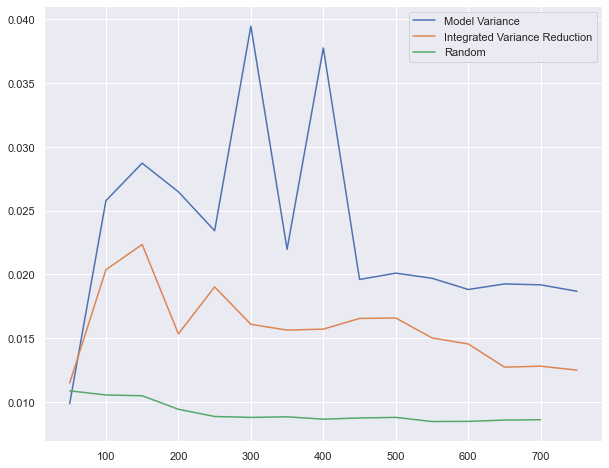

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
X_mv, Y_mv = zip(*mses_MV)
X_ivr, Y_ivr = zip(*mses_IVR)
X_rnd, Y_rnd = zip(*mses_RND)
ax.plot(X_mv, Y_mv, label='Model Variance')
ax.plot(X_ivr, Y_ivr, label='Integrated Variance Reduction')
ax.plot(X_rnd, Y_rnd, label='Random')
ax.legend()

### Save Models

In [42]:
with open(f'experimental_design/models/model_variance_20_init_points_750_loops_timeloss_per_distance.pkl', "wb") as f:
     pickle.dump(emukit_model_mv, f)

with open(f'experimental_design/models/integrated_variance_reduction_20_init_points_750_loops_timeloss_per_distance.pkl', "wb") as f:
     pickle.dump(emukit_model_ivr, f)
        
with open(f'experimental_design/models/770_random_points_supervised_GP_timeloss_per_distance.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)

### Dump whole session

In [43]:
import dill                            
dill.dump_session('5_params_timeloss_per_distance_session.pkl')

ValueError: __getstate__ not found in results object